In [28]:
import pandas as pd
import pandas as pd
import glob
import tqdm
import re
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
path = 'democrats' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,  error_bad_lines=False, warn_bad_lines=False)
    li.append(df)

democrats = pd.concat(li, axis=0, ignore_index=True)

In [3]:
path = 'republicans' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,  error_bad_lines=False, warn_bad_lines=False)
    li.append(df)

republicans = pd.concat(li, axis=0, ignore_index=True)

In [4]:
republicans["IsDemocrat"] = 0
democrats["IsDemocrat"] = 1
df = pd.concat([republicans, democrats], axis=0)

In [5]:
df.reset_index(drop=True, inplace=True)

In [6]:
# replace field that's entirely space (or empty) with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# drop rows that have no text values
df = df.dropna(subset=["Text"]) 

In [7]:
# Removing links from tweets

for index, value in tqdm.tqdm(enumerate(df["Text"].values)):
    clean_tweet = re.sub(r'http\S+', '', value)
    if clean_tweet:
        df["Text"][index] = clean_tweet

0it [00:00, ?it/s]C:\Users\cemsaftekindantel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
75915it [00:05, 14287.58it/s]


In [8]:
df = df[["Text", "IsDemocrat"]]

In [9]:
democrat_tweets = df[df["IsDemocrat"]==1]["Text"]
republican_tweets = df[df["IsDemocrat"]==0]["Text"]

In [10]:
def my_tokenizer(s):
    
    s = s.lower()
    
    # split string into words (tokens)
    tokens = nltk.tokenize.word_tokenize(s)
    
    # Removing words with less than 2 characters
    tokens = [t for t in tokens if len(t)>2]
    
    # Turning words into its base form
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    
    # Removing stopwords
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

In [11]:
stopwords = set(w.rstrip() for w in open("stopwords.txt"))

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

In [13]:
word_index_map = {}
current_index = 0



democrat_tokenized = []
republican_tokenized = []

for tweet in democrat_tweets:
    # Tokenize each review
    tokens = my_tokenizer(tweet)
    democrat_tokenized.append(tokens)
    for token in tokens:
        
        # Add the token as a key to the dictionary if it's not in it. Set the value of the key to it's index.
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index +=1
            
            
for tweet in republican_tweets:
    # Tokenize each review
    tokens = my_tokenizer(tweet)
    republican_tokenized.append(tokens)
    for token in tokens:
        
        # Add the token as a key to the dictionary if it's not in it. Set the value of the key to it's index.
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index +=1


In [14]:
def tokens_to_vector(tokens, label):
    # length of vocabulary + label length
    x = np.zeros(len(word_index_map)+1)
    for t in tokens:
        i = word_index_map[t]
        x[i] +=1
    x = x / x.sum()
    x[-1] = label
    return x

In [15]:
# Total observations
N = len(democrat_tokenized) + len(republican_tokenized)

data = np.zeros((N, len(word_index_map)+1))
i=0

for tokens in democrat_tokenized:
    # 1 for label
    xy = tokens_to_vector(tokens, 1)
    data[i,:] = xy
    i+=1
for tokens in republican_tokenized:
    # 0 for label
    xy = tokens_to_vector(tokens, 0)
    data[i,:] = xy
    i+=1

C:\Users\cemsaftekindantel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [16]:
# Shuffling our data before splitting 
np.random.shuffle(data)
X = data[:,:-1]
y = data[:,-1]

# Replacing nans with 0 in our features.
nan_positions = np.isnan(X)
X[nan_positions] = 0

In [17]:
# Splitting the data

X_train = X[:-30000,]
y_train = y[:-30000,]
X_test = X[-30000:,]
y_test = y[-30000:,]

In [18]:
# Baseline model with LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification rate {}.".format(accuracy_score(y_test, y_pred)))

C:\Users\cemsaftekindantel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification rate 0.7794666666666666.


In [19]:
# One hot encoding our labels and splitting them
y = to_categorical(y)

y_train = y[:-30000,]
y_test = y[-30000:,]

In [20]:
# Splitting our training data to train and validation sets for training
X_val = X_train[-15000:,]
X_train = X_train[:-15000,]
y_val = y_train[-15000:,]
y_train = y_train[:-15000,]

In [21]:
# Basic shallow-NN model with 2 hidden layers
def trainMulticlassSequential(X_train, y_train):
    n_cols = X_train.shape[1]
    model = Sequential()
    model.add(Dense(5, activation="relu", input_dim=n_cols))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(2, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=5, verbose=2, validation_data=(
        X_val, y_val))
    return model, history

In [22]:
# Our model performs quite well with a 80%+ accuracy on validation set
model, history = trainMulticlassSequential(X_train, y_train)

Train on 30915 samples, validate on 15000 samples
Epoch 1/5
 - 58s - loss: 0.5228 - accuracy: 0.7362 - val_loss: 0.4013 - val_accuracy: 0.8215
Epoch 2/5
 - 58s - loss: 0.2975 - accuracy: 0.8819 - val_loss: 0.3778 - val_accuracy: 0.8335
Epoch 3/5
 - 58s - loss: 0.1839 - accuracy: 0.9317 - val_loss: 0.3979 - val_accuracy: 0.8342
Epoch 4/5
 - 57s - loss: 0.1203 - accuracy: 0.9592 - val_loss: 0.4440 - val_accuracy: 0.8281
Epoch 5/5
 - 58s - loss: 0.0862 - accuracy: 0.9689 - val_loss: 0.4819 - val_accuracy: 0.8275


In [23]:
# Final classification score for the model is 82%
y_pred = model.predict(X_test)
print("Classification rate {}.".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))))

Classification rate 0.8199.


In [53]:
# Visualize the data

def visualize(label):
    words = ""
    for msg in df[df["IsDemocrat"]==label]["Text"]:
        msg = msg.lower()
        words += msg + " "
    wordcloud = WordCloud(width=600, height=400, background_color = "white").generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

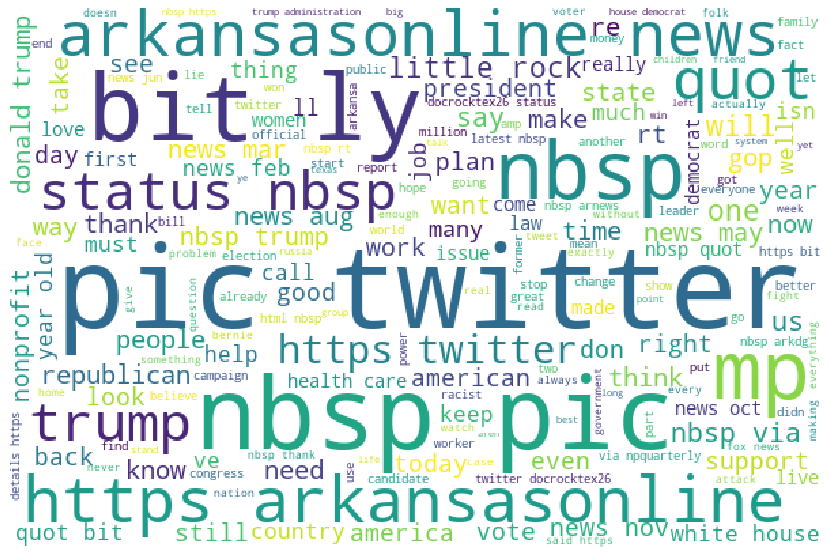

In [56]:
# Visualising words used by democrat influencers
fig = plt.figure(figsize=(20, 10))
visualize(1)

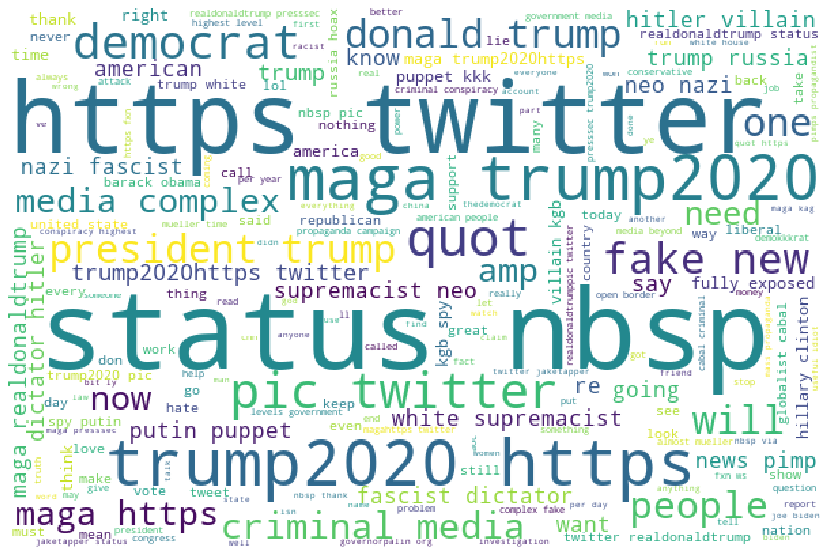

In [57]:
# Visualising words used by republican influencers
fig = plt.figure(figsize=(20, 10))
visualize(0)